In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-18 08:44:40.515904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import re

In [3]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 04.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 04 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [4]:
datapath = "../../../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [5]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [6]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [7]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [8]:
def prepare_data(features):
    sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
    
    scaler = StandardScaler()
    features_scaled = features.copy()
    features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])
    features_scaled = features_scaled[sensor_columns + ['activity']]
    
    print("columns : ", features_scaled.columns)
    adl_count = features_scaled['activity'].value_counts()[0]
    fall_count = features_scaled['activity'].value_counts()[1]

    # Split ADL data
    adl_mask = features_scaled['activity'] == 0
    adl_data = features_scaled[adl_mask]
    adl1 = adl_data.iloc[:int(adl_count * 0.8)]    # 80% for training
    adl2 = adl_data.iloc[int(adl_count * 0.8):]    # 20% for testing

    # Split Fall data
    fall_mask = features_scaled['activity'] == 1
    fall_data = features_scaled[fall_mask]
    fall1 = fall_data.iloc[:int(fall_count * 0.8)]  # 80% for training
    fall2 = fall_data.iloc[int(fall_count * 0.8):]  # 20% for testing
    
    # Prepare training data (only ADL data for training)
    train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)
    
    # Prepare test data (both ADL and Fall data)
    test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
    test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
    test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)
    
    # Combine all test data
    test_data = np.concatenate([test_adl_data, test_fall1_data, test_fall2_data])
    test_labels = np.concatenate([test_adl_labels, test_fall1_labels, test_fall2_labels])
    
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Train labels shape: {train_labels.shape}")
    print(f"Test labels shape: {test_labels.shape}")
    
    return train_data, test_data, test_labels

In [9]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [10]:
subject_id = 4
dfs_04 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_04.append(df)

features_04 = pd.concat(dfs_04, ignore_index=True)
features_04['activity'] = features_04['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)

print (features_04.isnull().sum())

100%|██████████████████████████████████████████| 746/746 [00:01<00:00, 551.63it/s]

rightpocket_acc_x    0
rightpocket_acc_y    0
rightpocket_acc_z    0
chest_acc_x          0
chest_acc_y          0
chest_acc_z          0
chest_gyro_x         0
chest_gyro_y         0
chest_gyro_z         0
chest_mag_x          0
chest_mag_y          0
chest_mag_z          0
wrist_acc_x          0
wrist_acc_y          0
wrist_acc_z          0
wrist_gyro_x         0
wrist_gyro_y         0
wrist_gyro_z         0
wrist_mag_x          0
wrist_mag_y          0
wrist_mag_z          0
waist_acc_x          0
waist_acc_y          0
waist_acc_z          0
waist_gyro_x         0
waist_gyro_y         0
waist_gyro_z         0
waist_mag_x          0
waist_mag_y          0
waist_mag_z          0
ankle_acc_x          0
ankle_acc_y          0
ankle_acc_z          0
ankle_gyro_x         0
ankle_gyro_y         0
ankle_gyro_z         0
ankle_mag_x          0
ankle_mag_y          0
ankle_mag_z          0
subject              0
activity             0
trial                0
dtype: int64


In [11]:
subject_id = 5
dfs_05 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_05.append(df)

features_05 = pd.concat(dfs_05, ignore_index=True)
features_05['activity'] = features_05['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
print (features_05.isnull().sum())

100%|██████████████████████████████████████████| 746/746 [00:01<00:00, 541.76it/s]

rightpocket_acc_x      0
rightpocket_acc_y      0
rightpocket_acc_z      0
chest_acc_x            0
chest_acc_y            0
chest_acc_z            0
chest_gyro_x           0
chest_gyro_y           0
chest_gyro_z           0
chest_mag_x            0
chest_mag_y            0
chest_mag_z            0
wrist_acc_x            0
wrist_acc_y            0
wrist_acc_z            0
wrist_gyro_x           0
wrist_gyro_y           0
wrist_gyro_z           0
wrist_mag_x            0
wrist_mag_y            0
wrist_mag_z            0
waist_acc_x            0
waist_acc_y            0
waist_acc_z            0
waist_gyro_x           0
waist_gyro_y           0
waist_gyro_z           0
waist_mag_x            0
waist_mag_y            0
waist_mag_z            0
ankle_acc_x          280
ankle_acc_y          280
ankle_acc_z          280
ankle_gyro_x         280
ankle_gyro_y         280
ankle_gyro_z         280
ankle_mag_x          280
ankle_mag_y          280
ankle_mag_z          280
subject                0


In [12]:
subject_id = 6
dfs_06 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_06.append(df)

features_06 = pd.concat(dfs_06, ignore_index=True)
features_06['activity'] = features_06['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
print (features_06.isnull().sum())

100%|██████████████████████████████████████████| 746/746 [00:01<00:00, 515.42it/s]


rightpocket_acc_x    0
rightpocket_acc_y    0
rightpocket_acc_z    0
chest_acc_x          0
chest_acc_y          0
chest_acc_z          0
chest_gyro_x         0
chest_gyro_y         0
chest_gyro_z         0
chest_mag_x          0
chest_mag_y          0
chest_mag_z          0
wrist_acc_x          0
wrist_acc_y          0
wrist_acc_z          0
wrist_gyro_x         0
wrist_gyro_y         0
wrist_gyro_z         0
wrist_mag_x          0
wrist_mag_y          0
wrist_mag_z          0
waist_acc_x          0
waist_acc_y          0
waist_acc_z          0
waist_gyro_x         0
waist_gyro_y         0
waist_gyro_z         0
waist_mag_x          0
waist_mag_y          0
waist_mag_z          0
ankle_acc_x          0
ankle_acc_y          0
ankle_acc_z          0
ankle_gyro_x         0
ankle_gyro_y         0
ankle_gyro_z         0
ankle_mag_x          0
ankle_mag_y          0
ankle_mag_z          0
subject              0
activity             0
trial                0
dtype: int64


In [13]:
# features_04 = features_04[[feature for feature in features_04.columns if 'ankle' not in feature]]
# features_05 = features_05[[feature for feature in features_05.columns if 'ankle' not in feature]]
# features_06 = features_06[[feature for feature in features_06.columns if 'ankle' not in feature]]

def handle_missing_values(df):
    df_interpolated = df.interpolate(method='linear', limit_direction='both')
    
    window_size = 40
    df_ma = df.rolling(window=window_size, center=True).mean()
    
    df_filled = df_interpolated.ffill().bfill()
    
    return df_filled

features_05 = handle_missing_values(features_05)

print("Missing values after handling:")
print("Subject 04:", features_04.isnull().sum().sum())
print("Subject 05:", features_05.isnull().sum().sum())
print("Subject 06:", features_06.isnull().sum().sum())

Missing values after handling:
Subject 04: 0
Subject 05: 0
Subject 06: 0


In [14]:
WINDOW_LENGTH = 40
STRIDE = 20

for subject_id in [4, 5, 6]:
    print(f"\nPreparing data for Subject {subject_id}")
    if subject_id == 4:
        train_data_04, test_data_04, test_labels_04 = prepare_data(features_04)
    elif subject_id == 5:
        train_data_05, test_data_05, test_labels_05 = prepare_data(features_05)
    else:
        train_data_06, test_data_06, test_labels_06 = prepare_data(features_06)


Preparing data for Subject 4
columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')
Train data shape: (356, 40, 39)
Test data shape: (247, 40, 39)
Train labels shape: (356,)
Test labels shape: (247,)

Preparing data for Subject 5
columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
     

-----

In [15]:
# Input:      (40, 39)
# Level 1:    (20, 64)   # spatial ↓2, channels ↑
# Level 2:    (10, 128)  # spatial ↓2, channels ↑
# Level 3:    (5, 256)   # spatial ↓2, channels ↑
# Bottleneck: (5, 512)   
# Level 3:    (10, 256)  # spatial ↑2, channels ↓
# Level 2:    (20, 128)  # spatial ↑2, channels ↓
# Level 1:    (40, 64)   # spatial ↑2, channels ↓
# Output:     (40, 39)

In [16]:
class DoubleConv(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DoubleConv, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(filters, 3, padding='same')  
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters, 3, padding='same') 
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.gelu = tf.keras.activations.gelu
        self.dropout = tf.keras.layers.Dropout(0.1)
    
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.gelu(x)
        x = self.dropout(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.gelu(x)
        x = self.dropout(x, training=training)
        return x

In [17]:
class UNetDiffusion(tf.keras.Model):
    def __init__(self):
        super(UNetDiffusion, self).__init__()
        
        # Encoder path with increased filters
        self.enc1 = tf.keras.Sequential([
            DoubleConv(64),  # Increased from 48
            tf.keras.layers.MaxPooling1D(2)  # (20, 64)
        ])
        
        self.enc2 = tf.keras.Sequential([
            DoubleConv(128),  # Increased from 96
            tf.keras.layers.MaxPooling1D(2)  # (10, 128)
        ])
        
        self.enc3 = tf.keras.Sequential([
            DoubleConv(256),  # New level
            tf.keras.layers.MaxPooling1D(2)  # (5, 256)
        ])
        
        # Enhanced bottleneck
        self.bottleneck = tf.keras.Sequential([
            DoubleConv(512),  # Increased from 192
            tf.keras.layers.Dropout(0.2)  # Additional dropout
        ])
        
        # Decoder path with increased filters
        self.dec3 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),
            DoubleConv(256)  # (10, 256)
        ])
        
        self.dec2 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),
            DoubleConv(128)  # (20, 128)
        ])
        
        self.dec1 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),
            DoubleConv(64)  # (40, 64)
        ])
        
        # Enhanced final convolution with correct activation layer
        self.final = tf.keras.Sequential([
            tf.keras.layers.Conv1D(64, 3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('gelu'),  # Changed from activations.gelu to layers.Activation
            tf.keras.layers.Conv1D(39, 1, padding='same')
        ])
        
        # Additional attention mechanism
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=64
        )
        
    def call(self, x, training=False):
        # Encoder path
        enc1_before_pool = x  # (40, 39)
        enc1_output = self.enc1(x, training=training)  # (20, 64)
        
        enc2_before_pool = enc1_output  # (20, 64)
        enc2_output = self.enc2(enc1_output, training=training)  # (10, 128)
        
        enc3_before_pool = enc2_output  # (10, 128)
        enc3_output = self.enc3(enc2_output, training=training)  # (5, 256)
        
        # Bottleneck with attention
        bottleneck = self.bottleneck(enc3_output, training=training)  # (5, 512)
        
        # Apply self-attention at the bottleneck
        attention_output = self.attention(
            bottleneck, bottleneck, 
            attention_mask=None, 
            training=training
        )
        bottleneck = bottleneck + attention_output  # Residual connection
        
        # Decoder path with skip connections
        dec3_output = self.dec3(bottleneck, training=training)  # (10, 256)
        dec3_output = tf.concat([enc3_before_pool, dec3_output], axis=-1)
        
        dec2_output = self.dec2(dec3_output, training=training)  # (20, 128)
        dec2_output = tf.concat([enc2_before_pool, dec2_output], axis=-1)
        
        dec1_output = self.dec1(dec2_output, training=training)  # (40, 64)
        dec1_output = tf.concat([enc1_before_pool, dec1_output], axis=-1)
        
        # Final output
        output = self.final(dec1_output)  # (40, 39)
        
        return output

In [18]:
def forward_diffusion(x, noise_level=0.1):  
    dtype = x.dtype
    noise = tf.random.normal(shape=tf.shape(x), dtype=dtype) * noise_level
    return x + noise

def anomaly_score(x_real, x_recon):
    return tf.reduce_mean(tf.abs(x_real - x_recon), axis=1)

In [19]:
BATCH_SIZE = 32
EPOCHS = 100
INITIAL_LEARNING_RATE = 1e-3 
DECAY_STEPS = 1000           # 500 -> 1000
DECAY_RATE = 0.98           # 0.95 -> 0.98

In [20]:
print("\nTraining model for Subject 04:")
model_04 = UNetDiffusion()
optimizer_04 = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        INITIAL_LEARNING_RATE, DECAY_STEPS, DECAY_RATE
    )
)

train_dataset_04 = tf.data.Dataset.from_tensor_slices(train_data_04.astype('float32'))
train_dataset_04 = train_dataset_04.batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = 0
    n_batches = len(train_data_04) // BATCH_SIZE
    
    pbar = tqdm(enumerate(train_dataset_04), 
                desc=f'Epoch {epoch+1}/{EPOCHS}', 
                total=n_batches,
                leave=False)
    
    for i, batch_data in pbar:
        with tf.GradientTape() as tape:
            noisy = forward_diffusion(batch_data, noise_level=0.1)
            reconstructed = model_04(noisy, training=True)
            loss = tf.reduce_mean(tf.square(reconstructed - batch_data))
        
        grads = tape.gradient(loss, model_04.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=0.5)
        optimizer_04.apply_gradients(zip(grads, model_04.trainable_variables))
        
        train_loss += loss.numpy()
        pbar.set_postfix({'Loss': f'{loss.numpy():.4f}'})
    
    avg_loss = train_loss / n_batches
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')


Training model for Subject 04:


Epoch 1/100: 12it [00:11,  1.21it/s, Loss=3.3991]                                 2025-02-18 08:45:02.947387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/100 - Loss: 1.4775


Epoch 2/100: 12it [00:08,  1.62it/s, Loss=3.0333]                                 2025-02-18 08:45:11.063837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/100 - Loss: 1.0994


Epoch 3/100: 12it [00:08,  1.51it/s, Loss=2.7928]                                 2025-02-18 08:45:19.119736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/100 - Loss: 0.9410


Epoch 4/100: 12it [00:08,  1.56it/s, Loss=2.5729]                                 2025-02-18 08:45:27.258743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/100 - Loss: 0.8445


Epoch 5/100: 12it [00:08,  1.55it/s, Loss=2.4069]                                 2025-02-18 08:45:35.334619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/100 - Loss: 0.7684


                                                                                  2025-02-18 08:45:43.716659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/100 - Loss: 0.7064


Epoch 7/100: 12it [00:07,  1.58it/s, Loss=2.1217]                                 2025-02-18 08:45:51.522176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/100 - Loss: 0.6557


Epoch 8/100: 12it [00:07,  1.71it/s, Loss=1.9803]                                 2025-02-18 08:45:58.910904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/100 - Loss: 0.6093


                                                 2025-02-18 08:46:06.146651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/100 - Loss: 0.5697


Epoch 10/100: 12it [00:07,  1.76it/s, Loss=1.7918]                                2025-02-18 08:46:13.386528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/100 - Loss: 0.5395


Epoch 11/100: 12it [00:07,  1.76it/s, Loss=1.6902]                                2025-02-18 08:46:20.643137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11/100 - Loss: 0.5103


Epoch 12/100: 12it [00:07,  1.76it/s, Loss=1.6092]                                2025-02-18 08:46:27.846456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12/100 - Loss: 0.4845


Epoch 13/100: 12it [00:07,  1.74it/s, Loss=1.5516]                                2025-02-18 08:46:35.116689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/100 - Loss: 0.4578


Epoch 14/100: 12it [00:07,  1.75it/s, Loss=1.4762]                                2025-02-18 08:46:42.343585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/100 - Loss: 0.4328


Epoch 15/100: 12it [00:07,  1.73it/s, Loss=1.4498]                                2025-02-18 08:46:49.621934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/100 - Loss: 0.4192


Epoch 16/100: 12it [00:07,  1.74it/s, Loss=1.3810]                                2025-02-18 08:46:56.893816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/100 - Loss: 0.3990


Epoch 17/100: 12it [00:07,  1.75it/s, Loss=1.3568]                                2025-02-18 08:47:04.148923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17/100 - Loss: 0.3862


Epoch 18/100: 12it [00:07,  1.75it/s, Loss=1.2801]                                2025-02-18 08:47:11.439234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18/100 - Loss: 0.3694


Epoch 19/100: 12it [00:07,  1.74it/s, Loss=1.2363]                                2025-02-18 08:47:18.710239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19/100 - Loss: 0.3536


Epoch 20/100: 12it [00:07,  1.73it/s, Loss=1.1934]                                2025-02-18 08:47:25.989032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20/100 - Loss: 0.3438


Epoch 21/100: 12it [00:07,  1.74it/s, Loss=1.1933]                                2025-02-18 08:47:33.258085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/100 - Loss: 0.3359


Epoch 22/100: 12it [00:07,  1.70it/s, Loss=1.1535]                                2025-02-18 08:47:40.674086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22/100 - Loss: 0.3231


Epoch 23/100: 12it [00:07,  1.74it/s, Loss=1.0998]                                2025-02-18 08:47:47.929585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23/100 - Loss: 0.3146


Epoch 24/100: 12it [00:07,  1.75it/s, Loss=1.0740]                                2025-02-18 08:47:55.200060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24/100 - Loss: 0.3024


Epoch 25/100: 12it [00:07,  1.76it/s, Loss=1.0412]                                2025-02-18 08:48:02.437064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25/100 - Loss: 0.2960


Epoch 26/100: 12it [00:07,  1.72it/s, Loss=1.0222]                                2025-02-18 08:48:09.722397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/100 - Loss: 0.2881


Epoch 27/100: 12it [00:07,  1.74it/s, Loss=0.9980]                                2025-02-18 08:48:17.015362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27/100 - Loss: 0.2796


Epoch 28/100: 12it [00:07,  1.75it/s, Loss=0.9681]                                2025-02-18 08:48:24.298001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28/100 - Loss: 0.2786


Epoch 29/100: 12it [00:07,  1.74it/s, Loss=0.9305]                                2025-02-18 08:48:31.595437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29/100 - Loss: 0.2625


Epoch 30/100: 12it [00:07,  1.75it/s, Loss=0.9081]                                2025-02-18 08:48:38.877571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30/100 - Loss: 0.2563


Epoch 31/100: 12it [00:07,  1.75it/s, Loss=0.8723]                                2025-02-18 08:48:46.146342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/100 - Loss: 0.2465


Epoch 32/100: 12it [00:07,  1.71it/s, Loss=0.8507]                                2025-02-18 08:48:53.502002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/100 - Loss: 0.2425


                                                  2025-02-18 08:49:00.799747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33/100 - Loss: 0.2457


Epoch 34/100: 12it [00:07,  1.76it/s, Loss=0.8400]                                2025-02-18 08:49:08.059488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34/100 - Loss: 0.2378


Epoch 35/100: 12it [00:07,  1.75it/s, Loss=0.8106]                                2025-02-18 08:49:15.335319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35/100 - Loss: 0.2361


Epoch 36/100: 12it [00:07,  1.75it/s, Loss=0.7953]                                2025-02-18 08:49:22.652197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36/100 - Loss: 0.2291


Epoch 37/100: 12it [00:07,  1.74it/s, Loss=0.7877]                                2025-02-18 08:49:29.930974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37/100 - Loss: 0.2275


Epoch 38/100: 12it [00:07,  1.75it/s, Loss=0.7640]                                2025-02-18 08:49:37.210939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38/100 - Loss: 0.2226


Epoch 39/100: 12it [00:07,  1.73it/s, Loss=0.7480]                                2025-02-18 08:49:44.563210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39/100 - Loss: 0.2215


Epoch 40/100: 12it [00:07,  1.74it/s, Loss=0.7287]                                2025-02-18 08:49:51.834420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40/100 - Loss: 0.2130


Epoch 41/100: 12it [00:07,  1.73it/s, Loss=0.7224]                                2025-02-18 08:49:59.133487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41/100 - Loss: 0.2052


Epoch 42/100: 12it [00:07,  1.72it/s, Loss=0.6974]                                2025-02-18 08:50:06.453587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42/100 - Loss: 0.1989


Epoch 43/100: 12it [00:07,  1.74it/s, Loss=0.6954]                                2025-02-18 08:50:13.753736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43/100 - Loss: 0.1961


Epoch 44/100: 12it [00:07,  1.72it/s, Loss=0.6832]                                2025-02-18 08:50:21.101979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44/100 - Loss: 0.1906


Epoch 45/100: 12it [00:07,  1.75it/s, Loss=0.6860]                                2025-02-18 08:50:28.404887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45/100 - Loss: 0.1910


                                                  2025-02-18 08:50:35.739739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46/100 - Loss: 0.1885


Epoch 47/100: 12it [00:07,  1.73it/s, Loss=0.6581]                                2025-02-18 08:50:43.063691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47/100 - Loss: 0.1874


                                                                                  2025-02-18 08:50:50.356133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48/100 - Loss: 0.1886


Epoch 49/100: 12it [00:07,  1.72it/s, Loss=0.6305]                                2025-02-18 08:50:57.733265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49/100 - Loss: 0.1793


                                                  2025-02-18 08:51:05.028335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50/100 - Loss: 0.1744


                                                  2025-02-18 08:51:12.349398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 51/100 - Loss: 0.1714


Epoch 52/100: 12it [00:07,  1.73it/s, Loss=0.5895]                                2025-02-18 08:51:19.642947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 52/100 - Loss: 0.1694


Epoch 53/100: 12it [00:07,  1.76it/s, Loss=0.5837]                                2025-02-18 08:51:26.859096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 53/100 - Loss: 0.1677


Epoch 54/100: 12it [00:07,  1.73it/s, Loss=0.5704]                                2025-02-18 08:51:34.154320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 54/100 - Loss: 0.1643


                                                  2025-02-18 08:51:41.459401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 55/100 - Loss: 0.1630


                                                                                  2025-02-18 08:51:48.765088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 56/100 - Loss: 0.1584


Epoch 57/100: 12it [00:07,  1.73it/s, Loss=0.5494]                                2025-02-18 08:51:56.111571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 57/100 - Loss: 0.1536


                                                  2025-02-18 08:52:03.454037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 58/100 - Loss: 0.1526


                                                  2025-02-18 08:52:10.758010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 59/100 - Loss: 0.1485


Epoch 60/100: 12it [00:07,  1.74it/s, Loss=0.5186]                                2025-02-18 08:52:18.016458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 60/100 - Loss: 0.1461


Epoch 61/100: 12it [00:07,  1.74it/s, Loss=0.5141]                                2025-02-18 08:52:25.321188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 61/100 - Loss: 0.1467


Epoch 62/100: 12it [00:07,  1.72it/s, Loss=0.5107]                                2025-02-18 08:52:32.659079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 62/100 - Loss: 0.1444


Epoch 63/100: 12it [00:07,  1.73it/s, Loss=0.5117]                                2025-02-18 08:52:39.982419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 63/100 - Loss: 0.1461


Epoch 64/100: 12it [00:07,  1.72it/s, Loss=0.4865]                                2025-02-18 08:52:47.306737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/100 - Loss: 0.1428


Epoch 65/100: 12it [00:07,  1.73it/s, Loss=0.4794]                                2025-02-18 08:52:54.646316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 65/100 - Loss: 0.1425


Epoch 66/100: 12it [00:07,  1.72it/s, Loss=0.4816]                                2025-02-18 08:53:02.001948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 66/100 - Loss: 0.1420


Epoch 67/100: 12it [00:07,  1.74it/s, Loss=0.4757]                                2025-02-18 08:53:09.296368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 67/100 - Loss: 0.1404


Epoch 68/100: 12it [00:07,  1.73it/s, Loss=0.4668]                                2025-02-18 08:53:16.608719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 68/100 - Loss: 0.1392


Epoch 69/100: 12it [00:07,  1.71it/s, Loss=0.4555]                                2025-02-18 08:53:23.986581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 69/100 - Loss: 0.1330


Epoch 70/100: 12it [00:07,  1.73it/s, Loss=0.4487]                                2025-02-18 08:53:31.353121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70/100 - Loss: 0.1324


Epoch 71/100: 12it [00:07,  1.73it/s, Loss=0.4388]                                2025-02-18 08:53:38.663374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 71/100 - Loss: 0.1311


Epoch 72/100: 12it [00:07,  1.73it/s, Loss=0.4370]                                2025-02-18 08:53:45.967496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 72/100 - Loss: 0.1307


Epoch 73/100: 12it [00:07,  1.72it/s, Loss=0.4257]                                2025-02-18 08:53:53.342039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 73/100 - Loss: 0.1262


Epoch 74/100: 12it [00:07,  1.75it/s, Loss=0.4156]                                2025-02-18 08:54:00.718338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 74/100 - Loss: 0.1254


Epoch 75/100: 12it [00:07,  1.75it/s, Loss=0.4187]                                2025-02-18 08:54:08.031698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 75/100 - Loss: 0.1245


Epoch 76/100: 12it [00:07,  1.73it/s, Loss=0.4075]                                2025-02-18 08:54:15.359636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 76/100 - Loss: 0.1218


Epoch 77/100: 12it [00:07,  1.73it/s, Loss=0.3992]                                2025-02-18 08:54:22.679544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 77/100 - Loss: 0.1202


Epoch 78/100: 12it [00:07,  1.74it/s, Loss=0.3953]                                2025-02-18 08:54:29.987737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 78/100 - Loss: 0.1175


Epoch 79/100: 12it [00:07,  1.72it/s, Loss=0.3921]                                2025-02-18 08:54:37.709935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 79/100 - Loss: 0.1176


Epoch 80/100: 12it [00:07,  1.73it/s, Loss=0.3879]                                2025-02-18 08:54:45.137576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 80/100 - Loss: 0.1201


Epoch 81/100: 12it [00:07,  1.75it/s, Loss=0.3941]                                2025-02-18 08:54:52.456418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 81/100 - Loss: 0.1172


Epoch 82/100: 12it [00:07,  1.73it/s, Loss=0.3810]                                2025-02-18 08:54:59.806068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 82/100 - Loss: 0.1163


Epoch 83/100: 12it [00:07,  1.73it/s, Loss=0.3742]                                2025-02-18 08:55:07.151958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 83/100 - Loss: 0.1131


                                                  2025-02-18 08:55:14.505840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 84/100 - Loss: 0.1140


Epoch 85/100: 12it [00:07,  1.73it/s, Loss=0.3650]                                2025-02-18 08:55:21.864710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 85/100 - Loss: 0.1105


                                                  2025-02-18 08:55:29.213379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 86/100 - Loss: 0.1080


Epoch 87/100: 12it [00:07,  1.74it/s, Loss=0.3455]                                2025-02-18 08:55:36.502164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 87/100 - Loss: 0.1066


Epoch 88/100: 12it [00:07,  1.72it/s, Loss=0.3413]                                2025-02-18 08:55:43.798301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 88/100 - Loss: 0.1069


Epoch 89/100: 12it [00:07,  1.75it/s, Loss=0.3392]                                2025-02-18 08:55:51.122838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 89/100 - Loss: 0.1068


Epoch 90/100: 12it [00:07,  1.72it/s, Loss=0.3350]                                2025-02-18 08:55:58.492175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 90/100 - Loss: 0.1057


Epoch 91/100: 12it [00:07,  1.73it/s, Loss=0.3297]                                2025-02-18 08:56:05.816487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 91/100 - Loss: 0.1037


Epoch 92/100: 12it [00:07,  1.74it/s, Loss=0.3236]                                2025-02-18 08:56:13.083649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 92/100 - Loss: 0.1028


Epoch 93/100: 12it [00:07,  1.72it/s, Loss=0.3293]                                2025-02-18 08:56:20.450408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 93/100 - Loss: 0.1040


Epoch 94/100: 12it [00:07,  1.73it/s, Loss=0.3150]                                2025-02-18 08:56:27.799379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 94/100 - Loss: 0.1042


Epoch 95/100: 12it [00:07,  1.72it/s, Loss=0.3183]                                2025-02-18 08:56:35.121749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 95/100 - Loss: 0.1027


Epoch 96/100: 12it [00:07,  1.70it/s, Loss=0.3032]                                2025-02-18 08:56:42.594163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 96/100 - Loss: 0.1004


Epoch 97/100: 12it [00:07,  1.72it/s, Loss=0.3015]                                2025-02-18 08:56:49.958978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 97/100 - Loss: 0.0981


Epoch 98/100: 12it [00:07,  1.71it/s, Loss=0.2936]                                2025-02-18 08:56:57.327077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 98/100 - Loss: 0.0955


Epoch 99/100: 12it [00:07,  1.70it/s, Loss=0.2904]                                2025-02-18 08:57:04.857658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 99/100 - Loss: 0.0953


                                                   2025-02-18 08:57:12.164621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100/100 - Loss: 0.0940


In [21]:
print("\nTraining model for Subject 05:")
model_05 = UNetDiffusion()
optimizer_05 = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        INITIAL_LEARNING_RATE, DECAY_STEPS, DECAY_RATE
    )
)

train_dataset_05 = tf.data.Dataset.from_tensor_slices(train_data_05.astype('float32'))
train_dataset_05 = train_dataset_05.batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = 0
    n_batches = len(train_data_05) // BATCH_SIZE
    
    pbar = tqdm(enumerate(train_dataset_05), 
                desc=f'Epoch {epoch+1}/{EPOCHS}', 
                total=n_batches,
                leave=False)
    
    for i, batch_data in pbar:
        with tf.GradientTape() as tape:
            noisy = forward_diffusion(batch_data, noise_level=0.1)
            reconstructed = model_05(noisy, training=True)
            loss = tf.reduce_mean(tf.square(reconstructed - batch_data))
        
        grads = tape.gradient(loss, model_05.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=0.5)
        optimizer_05.apply_gradients(zip(grads, model_05.trainable_variables))
        
        train_loss += loss.numpy()
        pbar.set_postfix({'Loss': f'{loss.numpy():.4f}'})
    
    avg_loss = train_loss / n_batches
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')


Training model for Subject 05:


Epoch 1/100: 12it [00:08,  1.68it/s, Loss=0.8555]                                 2025-02-18 08:57:20.911088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/100 - Loss: 1.2175


Epoch 2/100: 12it [00:07,  1.72it/s, Loss=0.6731]                                 2025-02-18 08:57:28.156845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/100 - Loss: 0.8884


Epoch 3/100: 12it [00:07,  1.70it/s, Loss=0.5771]                                 2025-02-18 08:57:35.429562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/100 - Loss: 0.7492


Epoch 4/100: 12it [00:07,  1.69it/s, Loss=0.5191]                                 2025-02-18 08:57:42.740649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/100 - Loss: 0.6661


Epoch 5/100: 12it [00:07,  1.69it/s, Loss=0.4705]                                 2025-02-18 08:57:50.031168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/100 - Loss: 0.6004


Epoch 6/100: 12it [00:07,  1.70it/s, Loss=0.4246]                                 2025-02-18 08:57:57.289392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/100 - Loss: 0.5480


Epoch 7/100: 12it [00:07,  1.69it/s, Loss=0.3955]                                 2025-02-18 08:58:04.561250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/100 - Loss: 0.5034


Epoch 8/100: 12it [00:07,  1.70it/s, Loss=0.3692]                                 2025-02-18 08:58:11.799348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/100 - Loss: 0.4678


Epoch 9/100: 12it [00:07,  1.71it/s, Loss=0.3441]                                 2025-02-18 08:58:19.062358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/100 - Loss: 0.4375


Epoch 10/100: 12it [00:07,  1.69it/s, Loss=0.3188]                                2025-02-18 08:58:26.409876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/100 - Loss: 0.4083


Epoch 11/100: 12it [00:07,  1.70it/s, Loss=0.2992]                                2025-02-18 08:58:33.682381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11/100 - Loss: 0.3799


Epoch 12/100: 12it [00:07,  1.70it/s, Loss=0.2801]                                2025-02-18 08:58:41.076922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12/100 - Loss: 0.3558


Epoch 13/100: 12it [00:07,  1.70it/s, Loss=0.2645]                                2025-02-18 08:58:48.333904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/100 - Loss: 0.3353


Epoch 14/100: 12it [00:07,  1.69it/s, Loss=0.2544]                                2025-02-18 08:58:55.618975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/100 - Loss: 0.3166


                                                  2025-02-18 08:59:02.884322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/100 - Loss: 0.2998


Epoch 16/100: 12it [00:07,  1.71it/s, Loss=0.2295]                                2025-02-18 08:59:10.129886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/100 - Loss: 0.2860


Epoch 17/100: 12it [00:07,  1.70it/s, Loss=0.2185]                                2025-02-18 08:59:17.409817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17/100 - Loss: 0.2740


Epoch 18/100: 12it [00:07,  1.69it/s, Loss=0.2049]                                2025-02-18 08:59:24.752880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18/100 - Loss: 0.2601


Epoch 19/100: 12it [00:07,  1.70it/s, Loss=0.2014]                                2025-02-18 08:59:32.004560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19/100 - Loss: 0.2516


Epoch 20/100: 12it [00:07,  1.70it/s, Loss=0.1954]                                2025-02-18 08:59:39.293767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20/100 - Loss: 0.2410


Epoch 21/100: 12it [00:07,  1.70it/s, Loss=0.1906]                                2025-02-18 08:59:46.528624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/100 - Loss: 0.2342


Epoch 22/100: 12it [00:07,  1.64it/s, Loss=0.1799]                                2025-02-18 08:59:54.121724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22/100 - Loss: 0.2243


Epoch 23/100: 12it [00:07,  1.66it/s, Loss=0.1809]                                2025-02-18 09:00:01.543654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23/100 - Loss: 0.2243


Epoch 24/100: 12it [00:07,  1.66it/s, Loss=0.1815]                                2025-02-18 09:00:09.075355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24/100 - Loss: 0.2154


Epoch 25/100: 12it [00:07,  1.68it/s, Loss=0.1776]                                2025-02-18 09:00:16.448287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25/100 - Loss: 0.2058


Epoch 26/100: 12it [00:07,  1.68it/s, Loss=0.1705]                                2025-02-18 09:00:23.769724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/100 - Loss: 0.1984


Epoch 27/100: 12it [00:07,  1.70it/s, Loss=0.1587]                                2025-02-18 09:00:31.062173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27/100 - Loss: 0.1913


Epoch 28/100: 12it [00:07,  1.68it/s, Loss=0.1618]                                2025-02-18 09:00:38.349657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28/100 - Loss: 0.1883


Epoch 29/100: 12it [00:07,  1.68it/s, Loss=0.1518]                                2025-02-18 09:00:45.639173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29/100 - Loss: 0.1820


Epoch 30/100: 12it [00:07,  1.70it/s, Loss=0.1519]                                2025-02-18 09:00:52.873996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30/100 - Loss: 0.1812


Epoch 31/100: 12it [00:07,  1.68it/s, Loss=0.1452]                                2025-02-18 09:01:00.226178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/100 - Loss: 0.1721


Epoch 32/100: 12it [00:07,  1.69it/s, Loss=0.1447]                                2025-02-18 09:01:07.533038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/100 - Loss: 0.1669


Epoch 33/100: 12it [00:07,  1.69it/s, Loss=0.1352]                                2025-02-18 09:01:14.806665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33/100 - Loss: 0.1609


Epoch 34/100: 12it [00:07,  1.70it/s, Loss=0.1316]                                2025-02-18 09:01:22.093444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34/100 - Loss: 0.1548


Epoch 35/100: 12it [00:07,  1.69it/s, Loss=0.1386]                                2025-02-18 09:01:29.405782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35/100 - Loss: 0.1514


Epoch 36/100: 12it [00:07,  1.70it/s, Loss=0.1331]                                2025-02-18 09:01:36.636663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36/100 - Loss: 0.1493


Epoch 37/100: 12it [00:07,  1.64it/s, Loss=0.1294]                                2025-02-18 09:01:44.097481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37/100 - Loss: 0.1454


Epoch 38/100: 12it [00:07,  1.69it/s, Loss=0.1257]                                2025-02-18 09:01:51.397515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38/100 - Loss: 0.1416


Epoch 39/100: 12it [00:07,  1.71it/s, Loss=0.1242]                                2025-02-18 09:01:58.734860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39/100 - Loss: 0.1386


Epoch 40/100: 12it [00:07,  1.70it/s, Loss=0.1223]                                2025-02-18 09:02:06.014936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40/100 - Loss: 0.1363


Epoch 41/100: 12it [00:07,  1.70it/s, Loss=0.1201]                                2025-02-18 09:02:13.298861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41/100 - Loss: 0.1353


Epoch 42/100: 12it [00:07,  1.69it/s, Loss=0.1149]                                2025-02-18 09:02:20.592566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42/100 - Loss: 0.1325


Epoch 43/100: 12it [00:07,  1.70it/s, Loss=0.1142]                                2025-02-18 09:02:27.861757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43/100 - Loss: 0.1287


                                                  2025-02-18 09:02:35.103124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44/100 - Loss: 0.1248


Epoch 45/100: 12it [00:07,  1.69it/s, Loss=0.1092]                                2025-02-18 09:02:42.394199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45/100 - Loss: 0.1216


Epoch 46/100: 12it [00:07,  1.72it/s, Loss=0.1060]                                2025-02-18 09:02:49.644007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46/100 - Loss: 0.1186


Epoch 47/100: 12it [00:07,  1.68it/s, Loss=0.1044]                                2025-02-18 09:02:56.953449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47/100 - Loss: 0.1180


Epoch 48/100: 12it [00:07,  1.69it/s, Loss=0.1066]                                2025-02-18 09:03:04.254141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48/100 - Loss: 0.1166


                                                  2025-02-18 09:03:11.566092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49/100 - Loss: 0.1164


Epoch 50/100: 12it [00:07,  1.68it/s, Loss=0.1032]                                2025-02-18 09:03:18.892246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50/100 - Loss: 0.1133


Epoch 51/100: 12it [00:07,  1.69it/s, Loss=0.1045]                                2025-02-18 09:03:26.182853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 51/100 - Loss: 0.1111


Epoch 52/100: 12it [00:07,  1.67it/s, Loss=0.1012]                                2025-02-18 09:03:33.533611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 52/100 - Loss: 0.1094


Epoch 53/100: 12it [00:07,  1.72it/s, Loss=0.0988]                                2025-02-18 09:03:40.731934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 53/100 - Loss: 0.1074


Epoch 54/100: 12it [00:07,  1.69it/s, Loss=0.0980]                                2025-02-18 09:03:48.027184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 54/100 - Loss: 0.1083


Epoch 55/100: 12it [00:07,  1.66it/s, Loss=0.0974]                                2025-02-18 09:03:55.425878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 55/100 - Loss: 0.1080


Epoch 56/100: 12it [00:07,  1.69it/s, Loss=0.1110]                                2025-02-18 09:04:02.748395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 56/100 - Loss: 0.1087


Epoch 57/100: 12it [00:07,  1.69it/s, Loss=0.0993]                                2025-02-18 09:04:10.039250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 57/100 - Loss: 0.1092


Epoch 58/100: 12it [00:07,  1.69it/s, Loss=0.0949]                                2025-02-18 09:04:17.327406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 58/100 - Loss: 0.1118


Epoch 59/100: 12it [00:07,  1.69it/s, Loss=0.0936]                                2025-02-18 09:04:24.622386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 59/100 - Loss: 0.1057


                                                                                  2025-02-18 09:04:31.975250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 60/100 - Loss: 0.1001


Epoch 61/100: 12it [00:07,  1.67it/s, Loss=0.0880]                                2025-02-18 09:04:39.311434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 61/100 - Loss: 0.0982


Epoch 62/100: 12it [00:07,  1.69it/s, Loss=0.0901]                                2025-02-18 09:04:46.611747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 62/100 - Loss: 0.0966


                                                  2025-02-18 09:04:53.954079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 63/100 - Loss: 0.0935


Epoch 64/100: 12it [00:07,  1.69it/s, Loss=0.0820]                                2025-02-18 09:05:01.275117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/100 - Loss: 0.0924


Epoch 65/100: 12it [00:07,  1.68it/s, Loss=0.0791]                                2025-02-18 09:05:08.638393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 65/100 - Loss: 0.0906


Epoch 66/100: 12it [00:07,  1.68it/s, Loss=0.0812]                                2025-02-18 09:05:15.955354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 66/100 - Loss: 0.0907


Epoch 67/100: 12it [00:07,  1.68it/s, Loss=0.0800]                                2025-02-18 09:05:23.315396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 67/100 - Loss: 0.0897


Epoch 68/100: 12it [00:07,  1.70it/s, Loss=0.0804]                                2025-02-18 09:05:30.589692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 68/100 - Loss: 0.0904


Epoch 69/100: 12it [00:07,  1.69it/s, Loss=0.0801]                                2025-02-18 09:05:37.877682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 69/100 - Loss: 0.0889


Epoch 70/100: 12it [00:07,  1.68it/s, Loss=0.0789]                                2025-02-18 09:05:45.165539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70/100 - Loss: 0.0870


                                                  2025-02-18 09:05:52.528687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 71/100 - Loss: 0.0878


Epoch 72/100: 12it [00:07,  1.66it/s, Loss=0.0736]                                2025-02-18 09:05:59.920885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 72/100 - Loss: 0.0841


Epoch 73/100: 12it [00:07,  1.68it/s, Loss=0.0701]                                2025-02-18 09:06:07.260628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 73/100 - Loss: 0.0822


                                                  2025-02-18 09:06:14.608340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 74/100 - Loss: 0.0815


Epoch 75/100: 12it [00:07,  1.68it/s, Loss=0.0710]                                2025-02-18 09:06:21.933936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 75/100 - Loss: 0.0805


                                                  2025-02-18 09:06:29.251535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 76/100 - Loss: 0.0794


Epoch 77/100: 12it [00:07,  1.68it/s, Loss=0.0696]                                2025-02-18 09:06:36.592734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 77/100 - Loss: 0.0793


Epoch 78/100: 12it [00:07,  1.68it/s, Loss=0.0688]                                2025-02-18 09:06:43.928466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 78/100 - Loss: 0.0791


Epoch 79/100: 12it [00:07,  1.68it/s, Loss=0.0668]                                2025-02-18 09:06:51.274589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 79/100 - Loss: 0.0779


Epoch 80/100: 12it [00:07,  1.59it/s, Loss=0.0712]                                2025-02-18 09:06:58.844870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 80/100 - Loss: 0.0795


Epoch 81/100: 12it [00:07,  1.68it/s, Loss=0.0657]                                2025-02-18 09:07:06.176065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 81/100 - Loss: 0.0762


Epoch 82/100: 12it [00:07,  1.69it/s, Loss=0.0656]                                2025-02-18 09:07:13.490332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 82/100 - Loss: 0.0758


Epoch 83/100: 12it [00:07,  1.67it/s, Loss=0.0672]                                2025-02-18 09:07:20.856662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 83/100 - Loss: 0.0766


Epoch 84/100: 12it [00:07,  1.70it/s, Loss=0.0668]                                2025-02-18 09:07:28.137903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 84/100 - Loss: 0.0749


Epoch 85/100: 12it [00:07,  1.48it/s, Loss=0.0642]                                2025-02-18 09:07:36.041457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 85/100 - Loss: 0.0746


Epoch 86/100: 12it [00:08,  1.49it/s, Loss=0.0634]                                2025-02-18 09:07:44.411147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 86/100 - Loss: 0.0726


Epoch 87/100: 12it [00:08,  1.44it/s, Loss=0.0631]                                2025-02-18 09:07:52.500629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 87/100 - Loss: 0.0728


                                                  2025-02-18 09:08:00.924599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 88/100 - Loss: 0.0718


                                                  2025-02-18 09:08:09.096532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 89/100 - Loss: 0.0712


Epoch 90/100: 12it [00:08,  1.34it/s, Loss=0.0616]                                2025-02-18 09:08:18.072786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 90/100 - Loss: 0.0700


Epoch 91/100: 12it [00:08,  1.55it/s, Loss=0.0630]                                2025-02-18 09:08:26.085114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 91/100 - Loss: 0.0694


Epoch 92/100: 12it [00:07,  1.62it/s, Loss=0.0623]                                2025-02-18 09:08:34.007322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 92/100 - Loss: 0.0684


Epoch 93/100: 12it [00:07,  1.68it/s, Loss=0.0590]                                2025-02-18 09:08:41.386014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 93/100 - Loss: 0.0681


Epoch 94/100: 12it [00:07,  1.69it/s, Loss=0.0592]                                2025-02-18 09:08:48.721032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 94/100 - Loss: 0.0685


Epoch 95/100: 12it [00:07,  1.66it/s, Loss=0.0563]                                2025-02-18 09:08:56.162938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 95/100 - Loss: 0.0682


Epoch 96/100: 12it [00:07,  1.68it/s, Loss=0.0643]                                2025-02-18 09:09:03.473249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 96/100 - Loss: 0.0689


Epoch 97/100: 12it [00:07,  1.64it/s, Loss=0.0640]                                2025-02-18 09:09:10.872378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 97/100 - Loss: 0.0678


Epoch 98/100: 12it [00:07,  1.65it/s, Loss=0.0575]                                2025-02-18 09:09:18.325507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 98/100 - Loss: 0.0659


Epoch 99/100: 12it [00:07,  1.68it/s, Loss=0.0589]                                2025-02-18 09:09:25.746780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 99/100 - Loss: 0.0670


Epoch 100/100: 12it [00:07,  1.68it/s, Loss=0.0552]                               2025-02-18 09:09:33.099012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
                                                   

Epoch 100/100 - Loss: 0.0654


In [22]:
print("\nTraining model for Subject 06:")
model_06 = UNetDiffusion()
optimizer_06 = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        INITIAL_LEARNING_RATE, DECAY_STEPS, DECAY_RATE
    )
)

train_dataset_06 = tf.data.Dataset.from_tensor_slices(train_data_06.astype('float32'))
train_dataset_06 = train_dataset_06.batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = 0
    n_batches = len(train_data_06) // BATCH_SIZE
    
    pbar = tqdm(enumerate(train_dataset_06), 
                desc=f'Epoch {epoch+1}/{EPOCHS}', 
                total=n_batches,
                leave=False)
    
    for i, batch_data in pbar:
        with tf.GradientTape() as tape:
            noisy = forward_diffusion(batch_data, noise_level=0.1)
            reconstructed = model_06(noisy, training=True)
            loss = tf.reduce_mean(tf.square(reconstructed - batch_data))
        
        grads = tape.gradient(loss, model_06.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=0.5)
        optimizer_06.apply_gradients(zip(grads, model_06.trainable_variables))
        
        train_loss += loss.numpy()
        pbar.set_postfix({'Loss': f'{loss.numpy():.4f}'})
    
    avg_loss = train_loss / n_batches
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')


Training model for Subject 06:


                                                 2025-02-18 09:09:42.249214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/100 - Loss: 1.4308


Epoch 2/100: 13it [00:07,  1.77it/s, Loss=0.5572]                                 2025-02-18 09:09:49.940475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/100 - Loss: 1.0366


                                                 2025-02-18 09:09:57.710057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/100 - Loss: 0.8712


Epoch 4/100: 13it [00:07,  1.76it/s, Loss=0.4279]                                 2025-02-18 09:10:05.446501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/100 - Loss: 0.7714


Epoch 5/100: 13it [00:07,  1.75it/s, Loss=0.3884]                                 2025-02-18 09:10:13.165402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/100 - Loss: 0.6960


Epoch 6/100: 13it [00:07,  1.74it/s, Loss=0.3568]                                 2025-02-18 09:10:20.923972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/100 - Loss: 0.6364


Epoch 7/100: 13it [00:07,  1.76it/s, Loss=0.3395]                                 2025-02-18 09:10:28.662971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/100 - Loss: 0.5848


Epoch 8/100: 13it [00:07,  1.75it/s, Loss=0.3354]                                 2025-02-18 09:10:36.448047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/100 - Loss: 0.5454


Epoch 9/100: 13it [00:07,  1.75it/s, Loss=0.3251]                                 2025-02-18 09:10:44.231771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/100 - Loss: 0.5098


Epoch 10/100: 13it [00:07,  1.74it/s, Loss=0.3199]                                2025-02-18 09:10:52.045632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/100 - Loss: 0.4772


Epoch 11/100: 13it [00:07,  1.77it/s, Loss=0.3101]                                2025-02-18 09:10:59.928149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11/100 - Loss: 0.4504


                                                  2025-02-18 09:11:07.710466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12/100 - Loss: 0.4226


Epoch 13/100: 13it [00:07,  1.75it/s, Loss=0.2666]                                2025-02-18 09:11:15.480867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/100 - Loss: 0.3998


                                                  2025-02-18 09:11:23.259606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/100 - Loss: 0.3787


Epoch 15/100: 13it [00:07,  1.73it/s, Loss=0.2450]                                2025-02-18 09:11:31.037009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/100 - Loss: 0.3594


Epoch 16/100: 13it [00:07,  1.76it/s, Loss=0.2367]                                2025-02-18 09:11:38.788125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/100 - Loss: 0.3445


Epoch 17/100: 13it [00:07,  1.75it/s, Loss=0.2337]                                2025-02-18 09:11:46.557616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17/100 - Loss: 0.3316


Epoch 18/100: 13it [00:07,  1.73it/s, Loss=0.2175]                                2025-02-18 09:11:54.393707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18/100 - Loss: 0.3176


Epoch 19/100: 13it [00:07,  1.73it/s, Loss=0.2116]                                2025-02-18 09:12:02.196036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19/100 - Loss: 0.3121


Epoch 20/100: 13it [00:07,  1.75it/s, Loss=0.2078]                                2025-02-18 09:12:10.007717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20/100 - Loss: 0.2946


Epoch 21/100: 13it [00:07,  1.75it/s, Loss=0.2012]                                2025-02-18 09:12:17.822527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/100 - Loss: 0.2854


Epoch 22/100: 13it [00:07,  1.74it/s, Loss=0.1916]                                2025-02-18 09:12:25.632999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22/100 - Loss: 0.2739


Epoch 23/100: 13it [00:07,  1.75it/s, Loss=0.2267]                                2025-02-18 09:12:33.411941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23/100 - Loss: 0.2665


Epoch 24/100: 13it [00:07,  1.76it/s, Loss=0.2090]                                2025-02-18 09:12:41.190408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24/100 - Loss: 0.2660


Epoch 25/100: 13it [00:07,  1.64it/s, Loss=0.1958]                                2025-02-18 09:12:49.114841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25/100 - Loss: 0.2638


Epoch 26/100: 13it [00:07,  1.72it/s, Loss=0.1989]                                2025-02-18 09:12:56.951492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/100 - Loss: 0.2611


Epoch 27/100: 13it [00:07,  1.78it/s, Loss=0.1850]                                2025-02-18 09:13:04.675333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27/100 - Loss: 0.2473


Epoch 28/100: 13it [00:07,  1.76it/s, Loss=0.1866]                                2025-02-18 09:13:12.425651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28/100 - Loss: 0.2399


Epoch 29/100: 13it [00:07,  1.76it/s, Loss=0.1772]                                2025-02-18 09:13:20.131329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29/100 - Loss: 0.2300


Epoch 30/100: 13it [00:07,  1.76it/s, Loss=0.1666]                                2025-02-18 09:13:27.877790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30/100 - Loss: 0.2211


Epoch 31/100: 13it [00:07,  1.76it/s, Loss=0.1681]                                2025-02-18 09:13:35.597041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/100 - Loss: 0.2158


Epoch 32/100: 13it [00:07,  1.76it/s, Loss=0.1655]                                2025-02-18 09:13:43.322385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/100 - Loss: 0.2100


Epoch 33/100: 13it [00:07,  1.74it/s, Loss=0.1625]                                2025-02-18 09:13:51.111113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33/100 - Loss: 0.2028


Epoch 34/100: 13it [00:07,  1.77it/s, Loss=0.1557]                                2025-02-18 09:13:58.891457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34/100 - Loss: 0.1982


Epoch 35/100: 13it [00:07,  1.73it/s, Loss=0.1625]                                2025-02-18 09:14:06.853940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35/100 - Loss: 0.1945


Epoch 36/100: 13it [00:07,  1.75it/s, Loss=0.1603]                                2025-02-18 09:14:14.609805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36/100 - Loss: 0.1910


Epoch 37/100: 13it [00:07,  1.74it/s, Loss=0.1618]                                2025-02-18 09:14:22.387497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37/100 - Loss: 0.1878


Epoch 38/100: 13it [00:07,  1.76it/s, Loss=0.1551]                                2025-02-18 09:14:30.158461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38/100 - Loss: 0.1852


Epoch 39/100: 13it [00:07,  1.77it/s, Loss=0.1469]                                2025-02-18 09:14:37.902908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39/100 - Loss: 0.1817


Epoch 40/100: 13it [00:07,  1.77it/s, Loss=0.1423]                                2025-02-18 09:14:45.627278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40/100 - Loss: 0.1816


Epoch 41/100: 13it [00:07,  1.77it/s, Loss=0.1469]                                2025-02-18 09:14:53.307849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41/100 - Loss: 0.1752


Epoch 42/100: 13it [00:07,  1.77it/s, Loss=0.1464]                                2025-02-18 09:15:01.018714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42/100 - Loss: 0.1742


Epoch 43/100: 13it [00:07,  1.76it/s, Loss=0.1410]                                2025-02-18 09:15:08.752000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43/100 - Loss: 0.1692


Epoch 44/100: 13it [00:07,  1.76it/s, Loss=0.1348]                                2025-02-18 09:15:16.471728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44/100 - Loss: 0.1663


                                                                                  2025-02-18 09:15:24.332434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45/100 - Loss: 0.1624


Epoch 46/100: 13it [00:07,  1.72it/s, Loss=0.1286]                                2025-02-18 09:15:32.210944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46/100 - Loss: 0.1597


Epoch 47/100: 13it [00:07,  1.74it/s, Loss=0.1274]                                2025-02-18 09:15:40.085850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47/100 - Loss: 0.1581


                                                                                  2025-02-18 09:15:47.823854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48/100 - Loss: 0.1553


Epoch 49/100: 13it [00:07,  1.75it/s, Loss=0.1335]                                2025-02-18 09:15:55.675127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49/100 - Loss: 0.1530


Epoch 50/100: 13it [00:07,  1.72it/s, Loss=0.1230]                                2025-02-18 09:16:03.524625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50/100 - Loss: 0.1488


Epoch 51/100: 13it [00:07,  1.75it/s, Loss=0.1274]                                2025-02-18 09:16:11.319687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 51/100 - Loss: 0.1474


Epoch 52/100: 13it [00:07,  1.75it/s, Loss=0.1231]                                2025-02-18 09:16:19.051297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 52/100 - Loss: 0.1443


Epoch 53/100: 13it [00:07,  1.77it/s, Loss=0.1304]                                2025-02-18 09:16:26.791744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 53/100 - Loss: 0.1455


Epoch 54/100: 13it [00:07,  1.75it/s, Loss=0.1215]                                2025-02-18 09:16:34.507802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 54/100 - Loss: 0.1440


Epoch 55/100: 13it [00:07,  1.77it/s, Loss=0.1173]                                2025-02-18 09:16:42.246380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 55/100 - Loss: 0.1411


Epoch 56/100: 13it [00:07,  1.76it/s, Loss=0.1164]                                2025-02-18 09:16:50.001456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 56/100 - Loss: 0.1412


Epoch 57/100: 13it [00:07,  1.75it/s, Loss=0.1150]                                2025-02-18 09:16:57.750144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 57/100 - Loss: 0.1367


                                                  2025-02-18 09:17:05.486547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 58/100 - Loss: 0.1368


Epoch 59/100: 13it [00:07,  1.76it/s, Loss=0.1131]                                2025-02-18 09:17:13.218159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 59/100 - Loss: 0.1383


Epoch 60/100: 13it [00:07,  1.77it/s, Loss=0.1244]                                2025-02-18 09:17:20.924389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 60/100 - Loss: 0.1369


Epoch 61/100: 13it [00:07,  1.77it/s, Loss=0.1209]                                2025-02-18 09:17:28.653741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 61/100 - Loss: 0.1376


Epoch 62/100: 13it [00:07,  1.77it/s, Loss=0.1086]                                2025-02-18 09:17:36.379278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 62/100 - Loss: 0.1352


Epoch 63/100: 13it [00:07,  1.75it/s, Loss=0.1085]                                2025-02-18 09:17:44.107417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 63/100 - Loss: 0.1344


Epoch 64/100: 13it [00:07,  1.73it/s, Loss=0.1097]                                2025-02-18 09:17:51.911448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/100 - Loss: 0.1294


Epoch 65/100: 13it [00:07,  1.75it/s, Loss=0.1020]                                2025-02-18 09:17:59.728232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 65/100 - Loss: 0.1255


Epoch 66/100: 13it [00:07,  1.75it/s, Loss=0.1027]                                2025-02-18 09:18:07.549165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 66/100 - Loss: 0.1243


Epoch 67/100: 13it [00:07,  1.62it/s, Loss=0.1004]                                2025-02-18 09:18:15.493923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 67/100 - Loss: 0.1216


Epoch 68/100: 13it [00:08,  1.70it/s, Loss=0.1052]                                2025-02-18 09:18:23.936694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 68/100 - Loss: 0.1194


Epoch 69/100: 13it [00:07,  1.74it/s, Loss=0.0968]                                2025-02-18 09:18:31.784334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 69/100 - Loss: 0.1198


Epoch 70/100: 13it [00:07,  1.72it/s, Loss=0.0979]                                2025-02-18 09:18:39.661196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70/100 - Loss: 0.1156


Epoch 71/100: 13it [00:07,  1.72it/s, Loss=0.0955]                                2025-02-18 09:18:47.562364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 71/100 - Loss: 0.1131


Epoch 72/100: 13it [00:07,  1.71it/s, Loss=0.0948]                                2025-02-18 09:18:55.511437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 72/100 - Loss: 0.1114


Epoch 73/100: 13it [00:07,  1.72it/s, Loss=0.0934]                                2025-02-18 09:19:03.411077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 73/100 - Loss: 0.1097


Epoch 74/100: 13it [00:07,  1.73it/s, Loss=0.0903]                                2025-02-18 09:19:11.319855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 74/100 - Loss: 0.1098


Epoch 75/100: 13it [00:07,  1.73it/s, Loss=0.0917]                                2025-02-18 09:19:19.228940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 75/100 - Loss: 0.1108


Epoch 76/100: 13it [00:08,  1.72it/s, Loss=0.0941]                                2025-02-18 09:19:27.340944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 76/100 - Loss: 0.1102


Epoch 77/100: 13it [00:07,  1.71it/s, Loss=0.0945]                                2025-02-18 09:19:35.259170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 77/100 - Loss: 0.1074


Epoch 78/100: 13it [00:07,  1.74it/s, Loss=0.0883]                                2025-02-18 09:19:43.120156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 78/100 - Loss: 0.1062


Epoch 79/100: 13it [00:07,  1.71it/s, Loss=0.0911]                                2025-02-18 09:19:51.032456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 79/100 - Loss: 0.1057


Epoch 80/100: 13it [00:07,  1.71it/s, Loss=0.0890]                                2025-02-18 09:19:58.952064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 80/100 - Loss: 0.1041


                                                  2025-02-18 09:20:06.802875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 81/100 - Loss: 0.1039


Epoch 82/100: 13it [00:08,  1.64it/s, Loss=0.0902]                                2025-02-18 09:20:14.882230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 82/100 - Loss: 0.1042


                                                  2025-02-18 09:20:22.812042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 83/100 - Loss: 0.1030


Epoch 84/100: 13it [00:07,  1.73it/s, Loss=0.0871]                                2025-02-18 09:20:30.737051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 84/100 - Loss: 0.1012


Epoch 85/100: 13it [00:07,  1.73it/s, Loss=0.0846]                                2025-02-18 09:20:38.650029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 85/100 - Loss: 0.0993


Epoch 86/100: 13it [00:07,  1.73it/s, Loss=0.0849]                                2025-02-18 09:20:46.558001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 86/100 - Loss: 0.0980


Epoch 87/100: 13it [00:07,  1.73it/s, Loss=0.0810]                                2025-02-18 09:20:54.480665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 87/100 - Loss: 0.0995


Epoch 88/100: 13it [00:07,  1.72it/s, Loss=0.0845]                                2025-02-18 09:21:02.371190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 88/100 - Loss: 0.1019


Epoch 89/100: 13it [00:07,  1.72it/s, Loss=0.0809]                                2025-02-18 09:21:10.287633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 89/100 - Loss: 0.1047


Epoch 90/100: 13it [00:07,  1.69it/s, Loss=0.0800]                                2025-02-18 09:21:18.265251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 90/100 - Loss: 0.1084


Epoch 91/100: 13it [00:07,  1.72it/s, Loss=0.0808]                                2025-02-18 09:21:26.207139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 91/100 - Loss: 0.1075


Epoch 92/100: 13it [00:07,  1.73it/s, Loss=0.5386]                                2025-02-18 09:21:34.086263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 92/100 - Loss: 0.1438


Epoch 93/100: 13it [00:07,  1.72it/s, Loss=0.1054]                                2025-02-18 09:21:42.005650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 93/100 - Loss: 0.1059


Epoch 94/100: 13it [00:07,  1.69it/s, Loss=0.0855]                                2025-02-18 09:21:49.957845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 94/100 - Loss: 0.1018


Epoch 95/100: 13it [00:07,  1.72it/s, Loss=0.0883]                                2025-02-18 09:21:57.869784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 95/100 - Loss: 0.1030


Epoch 96/100: 13it [00:07,  1.71it/s, Loss=0.0829]                                2025-02-18 09:22:05.838407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 96/100 - Loss: 0.0991


Epoch 97/100: 13it [00:07,  1.73it/s, Loss=0.0859]                                2025-02-18 09:22:13.775723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 97/100 - Loss: 0.0944


Epoch 98/100: 13it [00:07,  1.72it/s, Loss=0.0799]                                2025-02-18 09:22:21.726231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 98/100 - Loss: 0.0923


Epoch 99/100: 13it [00:07,  1.72it/s, Loss=0.0828]                                2025-02-18 09:22:29.640020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 99/100 - Loss: 0.0918


Epoch 100/100: 13it [00:07,  1.70it/s, Loss=0.0797]                               2025-02-18 09:22:37.565258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
                                                   

Epoch 100/100 - Loss: 0.0924


---

In [23]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [24]:
def evaluate_model(model, test_data, test_labels):
    valid_x_predictions = model.predict(test_data)
    error = flatten(test_data) - flatten(valid_x_predictions)
    valid_mse = np.mean(np.power(flatten(test_data) - flatten(valid_x_predictions), 2), axis=1)
    
    error_df = pd.DataFrame({
        'reconstruction_error': valid_mse,
        'true_class': test_labels
    })
    
    return error_df

In [25]:
error_df_04 = evaluate_model(model_04, test_data_04, test_labels_04)
error_df_05 = evaluate_model(model_05, test_data_05, test_labels_05)
error_df_06 = evaluate_model(model_06, test_data_06, test_labels_06)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [26]:
def plot_mse_distributions(models, train_data_list, test_data_list, subjects):
    plt.figure(figsize=(20, 5))
    
    for idx, (model, train_data, test_data, subject) in enumerate(zip(models, train_data_list, test_data_list, subjects)):
        plt.subplot(1, 3, idx + 1)
        
        # Calculate MSE for training data
        X_pred_train = model.predict(train_data)
        scored_train = np.mean(np.power((flatten(train_data) - flatten(X_pred_train)), 2), axis=1)
        
        # Calculate MSE for test data
        X_pred_test = model.predict(test_data)
        scored_test = np.mean(np.power((flatten(test_data) - flatten(X_pred_test)), 2), axis=1)
        
        plt.hist(scored_train, bins=30, color='blue', alpha=0.7, density=True, 
                histtype='step', label='Normal')
        plt.hist(scored_test, bins=30, color='red', alpha=0.7, density=True, 
                histtype='step', label='Abnormal')
        plt.title(f'Subject {subject} - MSE Distribution')
        plt.xlabel('MSE')
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [27]:
def plot_boxplots(error_dfs, subjects):
    plt.figure(figsize=(20, 5))
    
    for idx, (error_df, subject) in enumerate(zip(error_dfs, subjects)):
        plt.subplot(1, 3, idx + 1)
        sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False)
#         plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.title(f'Subject {subject} - Error Distribution')
        plt.ylabel('Reconstruction Error')
        plt.xlabel('Class (0: Normal, 1: Abnormal)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [28]:
def plot_reconstruction_errors(error_dfs, subjects, thresholds):
    plt.figure(figsize=(20, 5))
    
    for idx, (error_df, subject, threshold) in enumerate(zip(error_dfs, subjects, thresholds)):
        plt.subplot(1, 3, idx + 1)
        groups = error_df.groupby('true_class')
        
        for name, group in groups:
            plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
                    label="Normal" if name == 0 else "Fall")
            
        plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
        plt.title(f"Subject {subject} - Reconstruction Error by Class")
        plt.ylabel("Reconstruction Error")
        plt.xlabel("Data Point Index")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_confusion_matrices(error_dfs, subjects, thresholds):
    plt.figure(figsize=(20, 5))
    
    for idx, (error_df, subject, threshold) in enumerate(zip(error_dfs, subjects, thresholds)):
        plt.subplot(1, 3, idx + 1)
        
        y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
        conf_matrix = confusion_matrix(error_df.true_class, y_pred)
        
        sns.heatmap(conf_matrix, xticklabels=["Normal", "Fall"], 
                   yticklabels=["Normal", "Fall"], annot=True, fmt="d", cmap='Blues')
        plt.title(f"Subject {subject} - Confusion Matrix")
        plt.ylabel('True Class')
        plt.xlabel('Predicted Class')
    
    plt.tight_layout()
    plt.show()

In [30]:
models = [model_04, model_05, model_06]
train_data_list = [train_data_04, train_data_05, train_data_06]
test_data_list = [test_data_04, test_data_05, test_data_06]
error_dfs = [error_df_04, error_df_05, error_df_06]
subjects = [4, 5, 6]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


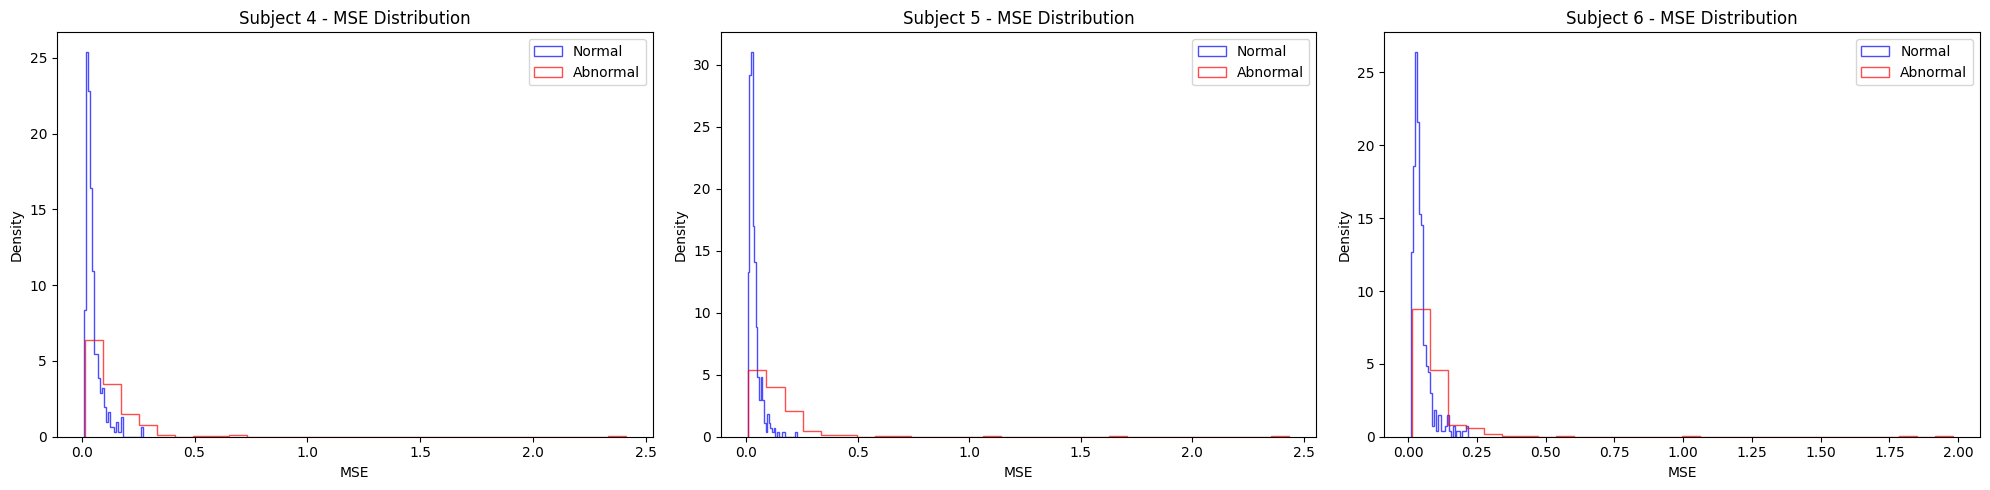

In [31]:
plot_mse_distributions(models, train_data_list, test_data_list, subjects)

/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_80143/3568542858.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_80143/3568542858.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_80143/3568542858.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


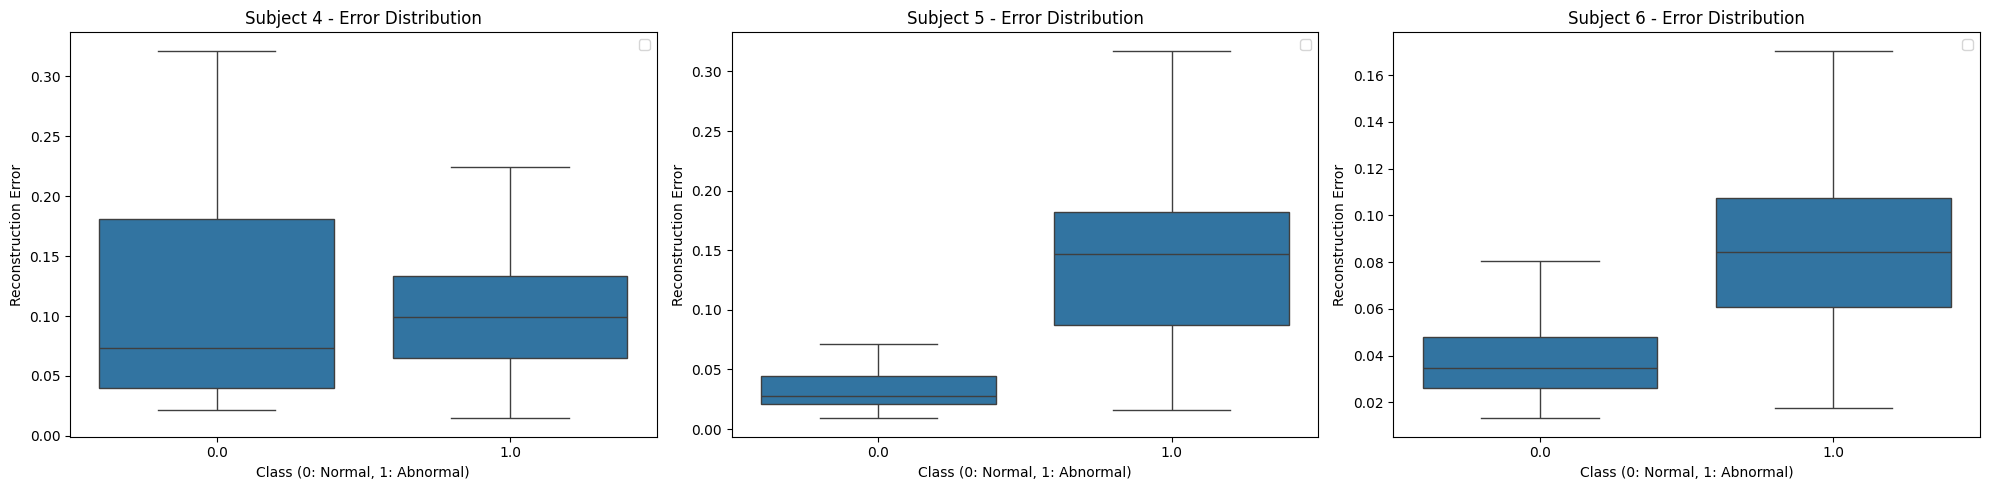

In [32]:
plot_boxplots(error_dfs, subjects)

In [37]:
thresholds = [
    np.percentile(error_df_04[error_df_04['true_class'] == 0]['reconstruction_error'], 60),
    np.percentile(error_df_05[error_df_05['true_class'] == 0]['reconstruction_error'], 85),
    np.percentile(error_df_06[error_df_06['true_class'] == 0]['reconstruction_error'], 85)
#     0.25,
#     0.15,
#     0.1
]

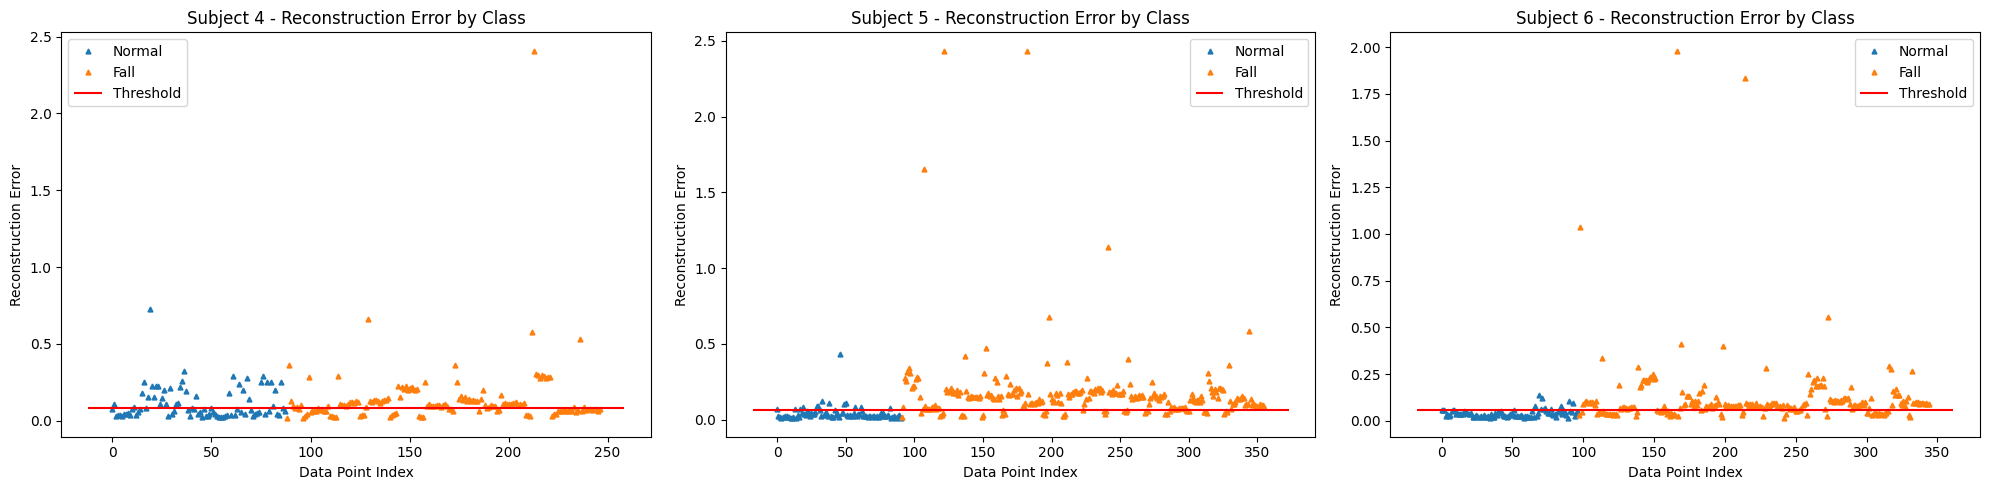

In [38]:
plot_reconstruction_errors(error_dfs, subjects, thresholds)

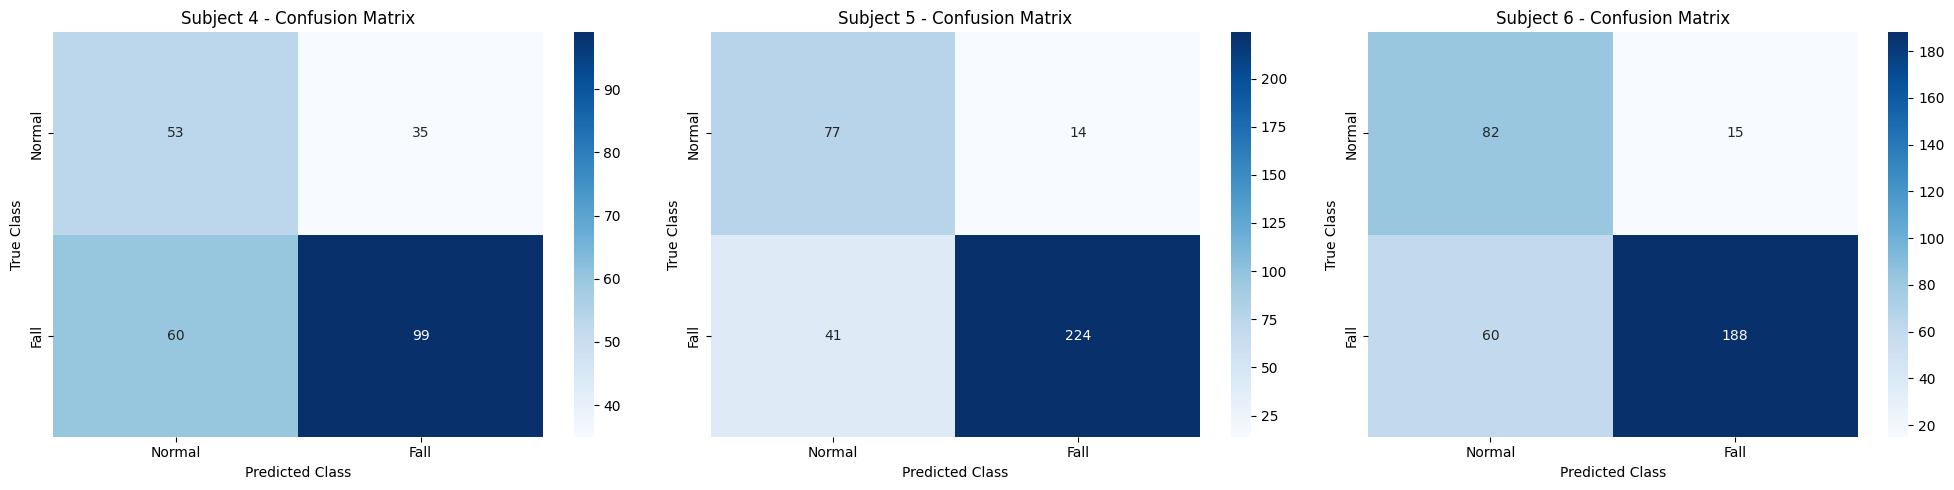

In [39]:
plot_confusion_matrices(error_dfs, subjects, thresholds)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for subject_id, error_df, threshold in zip(subjects, error_dfs, thresholds):
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    
    accuracy = accuracy_score(error_df.true_class, y_pred)
    precision = precision_score(error_df.true_class, y_pred)
    recall = recall_score(error_df.true_class, y_pred)
    f1 = f1_score(error_df.true_class, y_pred)
    
    print(f'\nSubject {subject_id} Performance:')
    print(f'Accuracy Score : {accuracy:.4f}')
    print(f'Precision     : {precision:.4f}')
    print(f'Recall        : {recall:.4f}')
    print(f'F1 Score      : {f1:.4f}')


Subject 4 Performance:
Accuracy Score : 0.6154
Precision     : 0.7388
Recall        : 0.6226
F1 Score      : 0.6758

Subject 5 Performance:
Accuracy Score : 0.8455
Precision     : 0.9412
Recall        : 0.8453
F1 Score      : 0.8907

Subject 6 Performance:
Accuracy Score : 0.7826
Precision     : 0.9261
Recall        : 0.7581
F1 Score      : 0.8337
